## Warehouse test

In [1]:
import os
import numpy as np
from environment import Environment
from openai import OpenAI
import copy
import configs
import pickle

os.environ["OPENAI_API_KEY"] = ""
client = OpenAI()

In [2]:
#negotiator를 구성하기 위한 union find 알고리즘

def find(parent, i):
    if parent[i] == i:
        return i
    else:
        return find(parent, parent[i])

def union(parent, rank, x, y):
    xroot = find(parent, x)
    yroot = find(parent, y)

    if xroot != yroot:
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

def merge_sets(lists):
    element_to_index = {}
    for i, subset in enumerate(lists):
        for element in subset:
            element_to_index[element] = i

    parent = [i for i in range(len(lists))]
    rank = [0] * len(lists)

    for subset in lists:
        first_element = subset[0]
        for element in subset[1:]:
            union(parent, rank, find(parent, element_to_index[first_element]), find(parent, element_to_index[element]))

    new_sets = {}
    for element in element_to_index:
        root = find(parent, element_to_index[element])
        if root not in new_sets:
            new_sets[root] = set()
        new_sets[root].add(element)

    return [list(s) for s in new_sets.values()]

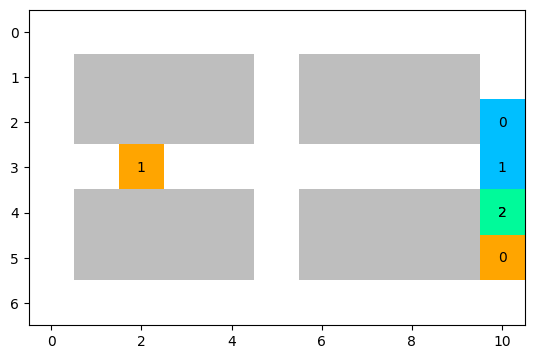

In [3]:
with open('./test_set/{}_{}agents.pth'.format('warehouse', 4), 'rb') as f:
    tests = pickle.load(f)

directiondict = {
    'stay': 0, 'north': 1, 'south': 2, 'west': 3, 'east': 4
}

# Toy example 만들기(환경, 처음 위치, 목적지)
toy = (np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), np.array([[2, 10], [3, 10], [4, 10]]), np.array([[5, 10], [3, 2], [4, 10]]))
num_agents = len(toy[1])
map_width = len(toy[0]) - 1

env = Environment()
env.load(toy[0], toy[1], toy[2])
env.render()

In [4]:
env.initialize_perceived_maps()
env.get_perceived_heuri_map()

In [5]:
env.update_perceived_maps()
env.get_perceived_heuri_map()

In [50]:
env.observe()[0][0][0][2:7, 2:7]

i = 0

In [6]:
env.observe()[0][0]

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 2, 0, 0, 0, 0],
        [0, 0, 0, 0, 3, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0

In [9]:
class gpt4pathfinding:
    def navigate(self, x, y, x_finish, y_finish, east, west, north, south, last_action, coordinates):
        response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a veteran adventurer with a great sense of direction. You understand which direction you need to move to get from where you are to where you want to go."},
            {"role": "user", "content":
                f"""
                Your current coordinates are ({x},{y}) and your destination is ({x_finish},{y_finish}).
                East and west in the coordinates correspond to the x axis.
                South and north in the coordinates correspond to the y axis.
                You can only move east, west, south and north or stay.
                So, your answer will be {{east}}, {{west}}, {{south}}, {{north}}, or {{stay}}.
                You can only make one move at a time.
                {east}
                {west}
                {south}
                {north}
                {last_action}
                Below is a list of the coordinates you visited.
                {coordinates}
                If you keep hovering over coordinates you've already visited, you're in a dead end, and it is recommended that you visit other place.

                Which direction do you move next?

                Consider whether moving in that direction will take you to the coordinates you visited.

                It is not allowed.

                Think step by step.

                Answer in one word only: {{direction or action}}"""
            }],
        )
        return response.choices[0].message.content
    
    def give_way(self, east, west, north, south, direction):
        response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a veteran adventurer with a great sense of direction. You understand which direction you need to move to get from where you are to where you want to go."},
            {"role": "user", "content":
                f"""
                You MUST avoid collisions with prior path finder.
                You can only move east, west, south and north or stay.
                So, your answer will be {{east}}, {{west}}, {{south}}, {{north}}, or {{stay}}.
                You can only make one move at a time.
                {east}
                {west}
                {south}
                {north}
                To the {direction} of you is prior path finder.
                Which direction do you move next?
                I highly recommend going to the 90-degree turn rather than the other side of the pathfinder, but you can ignore this instruction depending on your situation.
                
                Think step by step.

                Answer in one word only: {{direction or action}}"""
            }],
        )
        return response.choices[0].message.content


In [10]:
#에이전트들의 지난번 액션들과 좌표
action_list = [[] for _ in range(num_agents)]
coordinate_list = [[] for _ in range(num_agents)]

pathfinder = gpt4pathfinding()

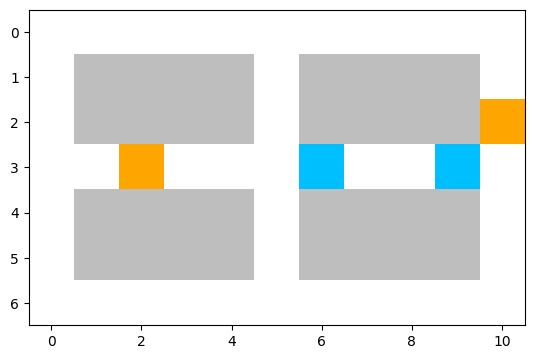

In [11]:
# 20 turn
for n in range(1):

  for i in range(num_agents):
     x_coordinate = env.observe()[1][i][1]
     y_coordinate = map_width-env.observe()[1][i][0]
     coordinate_list[i].append([x_coordinate, y_coordinate])

  step = [0 for i in range(num_agents)]

  #각 에이전트들의 시야에 있는 자신과 다른 에이전트들
  FOV_agents = []
  for i in range(num_agents):
    if np.any(env.observe()[0][i][0][2:7, 2:7]):
      non_zero_elements = env.observe()[0][i][0][2:7, 2:7][env.observe()[0][i][0][2:7, 2:7] != 0].tolist()
      non_zero_elements = [element - 1 for element in non_zero_elements]
      non_zero_elements.append(i)
      FOV_agents.append(non_zero_elements)

  #알고리즘을 이용해 연결된 집합 찾기
  connected_sets = merge_sets(FOV_agents)

  #연결이 있는 모든 에이전트들
  deadlocked_agents = [item for sublist in connected_sets for item in sublist]

  for i in range(num_agents):

    #교착상태에 빠지지 않은 에이전트는 독립적으로 navigate
    if i not in deadlocked_agents:
      
      a_obs = env.observe()[0][i][1]
      x = env.observe()[1][i][1]
      y = map_width-env.observe()[1][i][0]
      x_finish = toy[2][i][1]
      y_finish = map_width-toy[2][i][0]

      if a_obs[4][3] == 0:
        west = """To your west lies a path."""
      else:
        west = """Your west is blocked by a wall."""

      if a_obs[4][5] == 0:
        east = """To your east lies a path."""
      else:
        east = """Your east is blocked by a wall."""

      if a_obs[5][4] == 0:
        south = """To your south lies a path."""
      else:
        south = """Your south is blocked by a wall."""

      if a_obs[3][4] == 0:
        north = """To your north lies a path."""
      else:
        north = """Your north is blocked by a wall."""

      if len(action_list[i]) == 0:
        last_action = """"""
      elif action_list[i][-1] == 'west':
        last_action = f"""You came from east."""
      elif action_list[i][-1] == 'east':
        last_action = f"""You came from west."""
      elif action_list[i][-1] == 'south':
        last_action = f"""You came from north."""
      elif action_list[i][-1] == 'north':
        last_action = f"""You came from south."""
      elif action_list[i][-1] == 'stay':
        last_action = f"""You paused once for another agent or you reached your goal."""
      else:
        last_action = """"""

      coordinates = f"""{coordinate_list[i]}"""

      result = pathfinder.navigate(x, y, x_finish, y_finish, east, west, north, south, last_action, coordinates)

      result = result.lower().strip('.')

      if result not in directiondict:
        result = 'stay'

      action_list[i].append(result)

      step[i] = directiondict[result]
    
  
  # 교착상태에 빠진 에이전트에 대해
  for connected_set in connected_sets:
    
    results = []

    for i in connected_set: # 여기서 i는 agent의 번호들
    
    #각각의 에이전트에 대해 원래 계획된 경로를 계산

      a_obs = env.observe()[0][i][1]
      x = env.observe()[1][i][1]
      y = map_width-env.observe()[1][i][0]
      x_finish = toy[2][i][1]
      y_finish = map_width-toy[2][i][0]

      if a_obs[4][3] == 0:
        west = """To your west lies a path."""
      else:
        west = """Your west is blocked by a wall."""

      if a_obs[4][5] == 0:
        east = """To your east lies a path."""
      else:
        east = """Your east is blocked by a wall."""

      if a_obs[5][4] == 0:
        south = """To your south lies a path."""
      else:
        south = """Your south is blocked by a wall."""

      if a_obs[3][4] == 0:
        north = """To your north lies a path."""
      else:
        north = """Your north is blocked by a wall."""

      if len(action_list[i]) == 0:
        last_action = """"""
      elif action_list[i][-1] == 'west':
        last_action = f"""You came from east."""
      elif action_list[i][-1] == 'east':
        last_action = f"""You came from west."""
      elif action_list[i][-1] == 'south':
        last_action = f"""You came from north."""
      elif action_list[i][-1] == 'north':
        last_action = f"""You came from south."""
      elif action_list[i][-1] == 'stay':
        last_action = f"""You paused once for another agent or you reached your goal."""
      else:
        last_action = """"""

      coordinates = f"""{coordinate_list[i]}"""

      result = pathfinder.navigate(x, y, x_finish, y_finish, east, west, north, south, last_action, coordinates)

      result = result.lower().strip('.')

      if result not in directiondict:
        result = 'stay'

      results.append(result)

    env_copy = copy.deepcopy(env)
    planned_step = [0 for _ in range(num_agents)]
    for idx, agent_idx in enumerate(connected_set):
      planned_step[agent_idx] = directiondict[results[idx]]
    if -0.5 in env_copy.step(planned_step)[1]:
      collision = True
    else:
      collision = False

    if not collision:
      for idx, agent_idx in enumerate(connected_set):
        action_list[agent_idx].append(results[idx])
        step[agent_idx] = directiondict[results[idx]]
    # 충돌한다면 가장 큰 넘버의 에이전트가 우선권을 가지고, 나머지는 그를 피해가야 함 (이 부분을 좀더 정교화할 필요가 있음, 특히 3명 이상의 에이전트에 대한 경우. 일단 기본적으로는 얽힌 모든 에이전트가 가장 번호가 높은 에이전트에게서 도망가게.)
    # 특히, 먼저 도착한 에이전트는 장애물이 되어 그 멈춘 에이전트를 발견한 다른 에이전트의 heuristic map이 업데이트되어야 함 (멈춘 에이전트로 인해 예상치 못한 deadend가 생김)
    else:
    # 먼저 prior agent는 원래대로 이동하게 함
      prior_agent_number = max(connected_set)
      prior_agent_idx = connected_set.index(prior_agent_number)
      action_list[prior_agent_number].append(results[prior_agent_idx])
      step[prior_agent_number] = directiondict[results[prior_agent_idx]]
      for i in connected_set:
        if i != prior_agent_number:
            a_obs = env.observe()[0][i][1]
            x = env.observe()[1][i][1]
            y = map_width-env.observe()[1][i][0]
            x_finish = toy[2][i][1]
            y_finish = map_width-toy[2][i][0]

            if a_obs[4][3] == 0:
                west = """To your west lies a path."""
            else:
                west = """Your west is blocked by a wall."""

            if a_obs[4][5] == 0:
                east = """To your east lies a path."""
            else:
                east = """Your east is blocked by a wall."""

            if a_obs[5][4] == 0:
                south = """To your south lies a path."""
            else:
                south = """Your south is blocked by a wall."""

            if a_obs[3][4] == 0:
                north = """To your north lies a path."""
            else:
                north = """Your north is blocked by a wall."""

            # prior agent의 direction 구하기
            agent_map = env.observe()[0][i][0][2:7, 2:7]
            center = (2, 2)
            max_position = np.unravel_index(np.argmax(agent_map), agent_map.shape)

            row_diff = center[0] - max_position[0]
            col_diff = center[1] - max_position[1]

            if row_diff > 0 and col_diff > 0:
                direction = "northwest"
            elif row_diff > 0 and col_diff == 0:
                direction = "north"
            elif row_diff > 0 and col_diff < 0:
                direction = "northeast"
            elif row_diff == 0 and col_diff > 0:
                direction = "west"
            elif row_diff == 0 and col_diff < 0:
                direction = "east"
            elif row_diff < 0 and col_diff > 0:
                direction = "southwest"
            elif row_diff < 0 and col_diff == 0:
                direction = "south"
            elif row_diff < 0 and col_diff < 0:
                direction = "southeast"
            else:
                direction = "center"

            result = pathfinder.give_way(east, west, north, south, direction)

            result = result.lower().strip('.')

            if result not in directiondict:
              result = 'stay'

            action_list[i] = []
    
            step[i] = directiondict[result]


  env.step(step)
  env.render()

In [33]:
env.agents_pos

array([[3, 7],
       [3, 8]])

In [34]:
env.goals_pos

array([[ 2, 10],
       [ 3,  2]])

In [35]:
step_list = [0, 0]

In [37]:
for i in range(num_agents):
    if not np.array_equal(env.agents_pos[i], env.goals_pos[i]):
        step_list[i] += 1

In [38]:
step_list

[1, 1]

In [21]:
response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a veteran adventurer with a great sense of direction. You understand which direction you need to move to get from where you are to where you want to go."},
            {"role": "user", "content":
                f"""
                Your current coordinates are (0,3) and your destination is (10,5).
                East and west in the coordinates correspond to the x axis.
                South and north in the coordinates correspond to the y axis.
                You can only move east, west, south and north or stay.
                So, your answer will be {{east}}, {{west}}, {{south}}, {{north}}, or {{stay}}.
                You can only make one move at a time.
                To your east lies a path.
                To your west lies a path.
                To your south lies a path.
                To your north lies a path.
                Below is a list of the coordinates you visited.
                [[5, 3],
                [6, 3],
                [7, 3],
                [6, 3],
                [5, 3],
                [4, 3],
                [3, 3],
                [2, 3],
                [1, 3],
                [0, 3],
                [1, 3]]
                If you keep hovering over coordinates you've already visited, you're in a dead end, and it is recommended that you visit other place.

                Which direction do you move next?

                Consider whether moving in that direction will take you to the coordinates you visited.

                It is not allowed.

                Think step by step.

                Answer in one word only: {{direction or action}}"""
            }],
        )

response.choices[0].message.content

'east'

: 